In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv2
from PIL import Image
import os
import re
import json
from tqdm import tqdm

In [2]:
path =  "/Users/satoshan/Library/CloudStorage/GoogleDrive-sato41kawa0707@gmail.com/マイドライブ/scan_org_charts/data/cropped/"
path_json =  "/Users/satoshan/Library/CloudStorage/GoogleDrive-sato41kawa0707@gmail.com/マイドライブ/scan_org_charts/data/output/"
path_clean = "/Users/satoshan/Library/CloudStorage/GoogleDrive-sato41kawa0707@gmail.com/マイドライブ/scan_org_charts/data/clean/"
files = os.listdir(path)
files = [f for f in files if os.path.isfile(os.path.join(path, f))]
files = [f for f in files if f.lower().endswith('.png')]
files_json = os.listdir(path_json)
files_json = [f for f in files_json if os.path.isfile(os.path.join(path_json, f))]

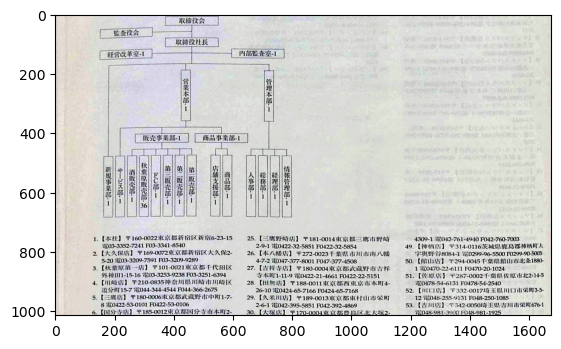

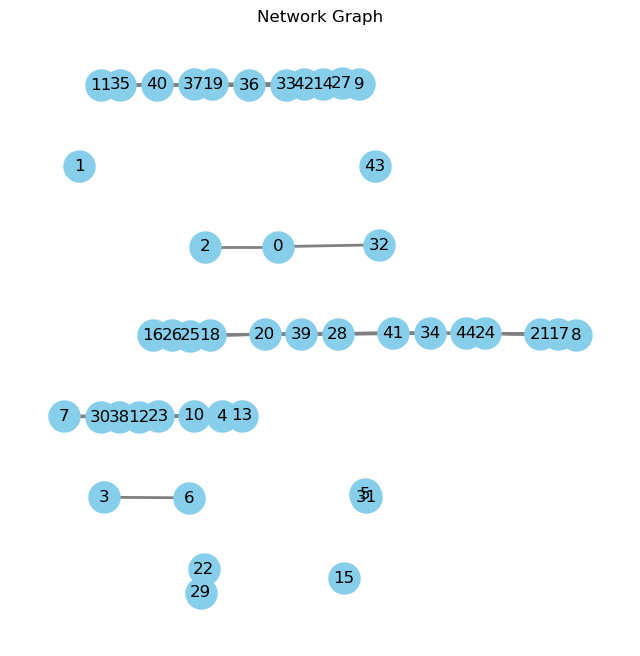

In [7]:
i = 1900
file = os.path.join(path, files[i])
file_json = os.path.join(path_json, files_json[i])
image = Image.open(file) 
image_width, image_height = image.size 
with open(file_json, "r") as f:
    data = json.load(f)
# the coordation of the centers of department
centers = []
for i, box in enumerate(data["pred_boxes"]):
    x_center = int((box[0] + box[2]) / 2)
    y_center = int((box[1] + box[3]) / 2)

    # Normalize the image size
    x_normalized = (x_center / image_width) * 10
    y_normalized = (y_center / image_height) * 10
    centers.append({"id": i, "center": (x_normalized, y_normalized)})

# make graph
G = nx.Graph()
# Add nodes to graph
for center in centers:
    G.add_node(center["id"], pos=center["center"])
# Add edges to graph 
distance_threshold_lower= 0.001
distance_threshold_upper= 3
for i in range(len(centers)):
    for j in range(i + 1, len(centers)):
        dist = np.linalg.norm(np.array(centers[i]["center"]) - np.array(centers[j]["center"]))
        if dist < distance_threshold_upper and dist > distance_threshold_lower:
            G.add_edge(centers[i]["id"], centers[j]["id"], weight=dist)

pos = nx.get_node_attributes(G, "pos")

plt.imshow(image)
plt.show()

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12)
plt.title("Network Graph")
plt.axis('off')
plt.show()

In [4]:
results = []

for i in tqdm(range(len(files)), desc="Processing files"):
    file = os.path.join(path, files[i])
    file_json = os.path.join(path_json, files_json[i])
    image = Image.open(file) 
    image_width, image_height = image.size 
    with open(file_json, "r") as f:
        data = json.load(f)
    # the coordation of the centers of department
    centers = []
    for i, box in enumerate(data["pred_boxes"]):
        x_center = int((box[0] + box[2]) / 2)
        y_center = int((box[1] + box[3]) / 2)

        # Normalize the image size
        x_normalized = (x_center / image_width) * 10
        y_normalized = (y_center / image_height) * 10
        centers.append({"id": i, "center": (x_normalized, y_normalized)})

    # make graph
    G = nx.Graph()
    # Add nodes to graph
    for center in centers:
        G.add_node(center["id"], pos=center["center"])
    # Add edges to graph 
    distance_threshold_lower= 0.001
    distance_threshold_upper= 3
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            dist = np.linalg.norm(np.array(centers[i]["center"]) - np.array(centers[j]["center"]))
            if dist < distance_threshold_upper and dist > distance_threshold_lower:
                G.add_edge(centers[i]["id"], centers[j]["id"], weight=dist)

    pos = nx.get_node_attributes(G, "pos")

    if len(G) == 0:
        avg_length = None
    elif nx.is_connected(G):
        avg_length = nx.average_shortest_path_length(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        avg_length = nx.average_shortest_path_length(subgraph)

    num_depart = len(centers)
    match = re.search(r"(\d{4})_(\d{4})", file)
    if match:
        year = match.group(1)  # Extracts the year (e.g., "2002")
        code = match.group(2)  # Extracts the code (e.g., "7003")
    else:
        year = None
        code = None

    results.append({"code": code, "year": year , "shortest_path_length": avg_length, "num_depart": num_depart})


Processing files: 100%|██████████| 2091/2091 [35:25<00:00,  1.02s/it]


In [5]:
df = pd.DataFrame(results)
df.to_csv(os.path.join(path_clean, "org_data.csv"))